# Import Lib
Neural machine translation with a Transformer and Keras - https://www.tensorflow.org/text/tutorials/transformer#the_transformer

In [1]:
#!pip install tensorflow_text
!pip install nsepythonserver

In [2]:
!pip uninstall -y tensorflow keras

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0


In [3]:
!pip install tensorflow==2.15.0 keras==2.15.0

  Using cached tensorflow-2.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow-2.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.3 MB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.15.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.15.0 which is incompatible.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15,8]
import seaborn as sns
import plotly.graph_objects as go

In [5]:
from nsepythonserver import equity_history
from datetime import date, datetime, timedelta

In [6]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Layer, MultiHeadAttention, LayerNormalization, Conv1D, Multiply, Softmax
from tensorflow.keras.layers import Add, Dense, Dropout, Flatten, Concatenate, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.math import rsqrt, minimum
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback
from tensorflow.keras.models import load_model, save_model
#from tensorflow.keras.ops import round as tf_round
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.backend import set_value
from tensorflow.signal import stft, hann_window

In [7]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

# Output must be
# TensorFlow version: 2.15.0
# Keras version: 2.15.0

TensorFlow version: 2.15.0
Keras version: 2.15.0


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error

In [9]:
from tensorflow.keras import initializers

initializer_for_relu = initializers.HeNormal() # For layers with activation function Relu
initializer_for_sigmoid = initializers.GlorotNormal() # For layers with activation function Sigmoid

In [10]:
import warnings
warnings.filterwarnings('ignore')

# Import Data

In [11]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [136]:
#symbol = ['BPCL','POWERGRID','NTPC','SUNPHARMA','TATACONSUM','ONGC','HINDALCO','ICICIBANK','SBIN','BHARTIARTL',
#           'WIPRO','ITC','AXISBANK','JSWSTEEL','COALINDIA','HDFCLIFE','TATAMOTORS']

symbol = ['IOC','TATASTEEL','ONGC','POWERGRID']
series = "EQ"

#start_date = datetime.now() - timedelta(256)
prod_date = "09-10-2024"
start_date = datetime.strftime(datetime.strptime(prod_date, '%d-%m-%Y')  - timedelta(256), '%d-%m-%Y')
print('Start Date =',start_date)
yesterday = datetime.now() - timedelta(1)
end_date = datetime.strftime(yesterday, '%d-%m-%Y')
print('End Date =',end_date)

Start Date = 27-01-2024
End Date = 02-03-2025


In [137]:
Company_selection = 0

In [138]:
data_df = pd.DataFrame(equity_history(symbol[Company_selection],series,start_date,end_date))
data_df

,_id,CH_SYMBOL,CH_SERIES,CH_MARKET_TYPE,CH_TIMESTAMP,TIMESTAMP,CH_TRADE_HIGH_PRICE,CH_TRADE_LOW_PRICE,CH_OPENING_PRICE,CH_CLOSING_PRICE,...,CH_52WEEK_LOW_PRICE,CH_TOTAL_TRADES,CH_ISIN,createdAt,updatedAt,__v,SLBMH_TOT_VAL,VWAP,mTIMESTAMP,CA
0,678f8c7fe7a37c0f45c8c07b,IOC,EQ,N,2025-01-21,2025-01-20T18:30:00.000Z,133.66,130.65,131.70,131.08,...,121.16,205763,INE242A01010,2025-01-21T12:01:03.976Z,2025-01-21T12:01:03.976Z,0,None,132.00,21-Jan-2025,NaN
1,6790ddff6bdd837c9fe69df9,IOC,EQ,N,2025-01-22,2025-01-21T18:30:00.000Z,132.60,128.44,132.20,130.52,...,121.16,74474,INE242A01010,2025-01-22T12:01:03.243Z,2025-01-22T12:01:03.243Z,0,None,129.93,22-Jan-2025,NaN
2,67922f7f9a3fa4a103120182,IOC,EQ,N,2025-01-23,2025-01-22T18:30:00.000Z,130.69,128.84,130.40,129.83,...,121.16,74363,INE242A01010,2025-01-23T12:01:03.331Z,2025-01-23T12:01:03.331Z,0,None,129.72,23-Jan-2025,NaN
3,679380ff61596ed1d929cb54,IOC,EQ,N,2025-01-24,2025-01-23T18:30:00.000Z,132.75,127.90,130.99,128.26,...,121.16,93340,INE242A01010,2025-01-24T12:01:03.517Z,2025-01-24T12:01:03.517Z,0,None,129.93,24-Jan-2025,NaN
4,67977580e3454e94c491e2f0,IOC,EQ,N,2025-01-27,2025-01-26T18:30:00.000Z,127.97,122.50,127.97,124.17,...,121.16,172792,INE242A01010,2025-01-27T12:01:04.058Z,2025-01-27T12:01:04.058Z,0,None,125.23,27-Jan-2025,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,65e3a21042d7e8ee3d2e7ebb,IOC,EQ,N,2024-03-02,2024-03-01T18:30:00.000Z,172.75,169.40,169.95,172.20,...,75.75,21926,INE242A01010,2024-03-02T22:02:56.219Z,2024-03-02T22:02:56.219Z,0,None,171.35,02-Mar-2024,NaN
276,65e5b7ffb33976f8b974ce47,IOC,EQ,N,2024-03-04,2024-03-03T18:30:00.000Z,176.45,170.50,172.20,175.25,...,75.75,142460,INE242A01010,2024-03-04T12:01:03.307Z,2024-03-04T12:01:03.307Z,0,None,174.39,04-Mar-2024,NaN
277,65e7097fa0e4c105af47e4c7,IOC,EQ,N,2024-03-05,2024-03-04T18:30:00.000Z,177.30,174.55,176.45,175.85,...,75.75,101990,INE242A01010,2024-03-05T12:01:03.722Z,2024-03-05T12:01:03.722Z,0,None,175.77,05-Mar-2024,NaN
278,65e85aff3d619fdb6b8a1b3f,IOC,EQ,N,2024-03-06,2024-03-05T18:30:00.000Z,178.20,172.10,176.20,177.35,...,75.75,145075,INE242A01010,2024-03-06T12:01:03.256Z,2024-03-06T12:01:03.256Z,0,None,175.55,06-Mar-2024,NaN


In [139]:
data_df.columns

Index(['_id', 'CH_SYMBOL', 'CH_SERIES', 'CH_MARKET_TYPE', 'CH_TIMESTAMP',
       'TIMESTAMP', 'CH_TRADE_HIGH_PRICE', 'CH_TRADE_LOW_PRICE',
       'CH_OPENING_PRICE', 'CH_CLOSING_PRICE', 'CH_LAST_TRADED_PRICE',
       'CH_PREVIOUS_CLS_PRICE', 'CH_TOT_TRADED_QTY', 'CH_TOT_TRADED_VAL',
       'CH_52WEEK_HIGH_PRICE', 'CH_52WEEK_LOW_PRICE', 'CH_TOTAL_TRADES',
       'CH_ISIN', 'createdAt', 'updatedAt', '__v', 'SLBMH_TOT_VAL', 'VWAP',
       'mTIMESTAMP', 'CA'],
      dtype='object')

# Data Preprocessing

## Data Visualisations

In [140]:
data_df_select = data_df[['TIMESTAMP','mTIMESTAMP','CH_OPENING_PRICE','CH_TRADE_HIGH_PRICE',
                          'CH_TRADE_LOW_PRICE','CH_LAST_TRADED_PRICE']].sort_values(['TIMESTAMP'], ascending=[True]).copy()

In [141]:
data_df_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280 entries, 250 to 28
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TIMESTAMP             280 non-null    object 
 1   mTIMESTAMP            280 non-null    object 
 2   CH_OPENING_PRICE      280 non-null    float64
 3   CH_TRADE_HIGH_PRICE   280 non-null    float64
 4   CH_TRADE_LOW_PRICE    280 non-null    float64
 5   CH_LAST_TRADED_PRICE  280 non-null    float64
dtypes: float64(4), object(2)
memory usage: 15.3+ KB


In [142]:
data_df_select.shape

(280, 6)

### Drop Duplicate rows

In [143]:
data_df_select.drop_duplicates(ignore_index = True).shape

(273, 6)

In [144]:
data_df_select.drop_duplicates(ignore_index = True, inplace=True)

In [145]:
data_df_select[data_df_select.TIMESTAMP == '2024-08-06T18:30:00.000Z']

,TIMESTAMP,mTIMESTAMP,CH_OPENING_PRICE,CH_TRADE_HIGH_PRICE,CH_TRADE_LOW_PRICE,CH_LAST_TRADED_PRICE
130,2024-08-06T18:30:00.000Z,07-Aug-2024,171.24,172.5,169.07,172.3


### Set Index

In [146]:
data_df_select.set_index(data_df_select.mTIMESTAMP, verify_integrity=True, drop=True, inplace=True)

In [147]:
data_df_select

,TIMESTAMP,mTIMESTAMP,CH_OPENING_PRICE,CH_TRADE_HIGH_PRICE,CH_TRADE_LOW_PRICE,CH_LAST_TRADED_PRICE
mTIMESTAMP,,,,,,
29-Jan-2024,2024-01-28T18:30:00.000Z,29-Jan-2024,143.70,148.40,143.50,147.05
30-Jan-2024,2024-01-29T18:30:00.000Z,30-Jan-2024,148.40,152.20,146.50,148.10
31-Jan-2024,2024-01-30T18:30:00.000Z,31-Jan-2024,147.80,150.10,146.10,147.25
01-Feb-2024,2024-01-31T18:30:00.000Z,01-Feb-2024,148.50,150.70,147.05,149.90
02-Feb-2024,2024-02-01T18:30:00.000Z,02-Feb-2024,151.90,166.80,151.05,163.25
...,...,...,...,...,...,...
21-Feb-2025,2025-02-20T18:30:00.000Z,21-Feb-2025,122.00,123.71,120.83,121.74
24-Feb-2025,2025-02-23T18:30:00.000Z,24-Feb-2025,120.25,121.31,119.40,120.35
25-Feb-2025,2025-02-24T18:30:00.000Z,25-Feb-2025,120.22,120.71,118.40,118.62


### Selecting only required columns

In [148]:
data_df_select.drop(labels=['TIMESTAMP','mTIMESTAMP'], axis=1, inplace=True)

In [149]:
data_df_select.columns

Index(['CH_OPENING_PRICE', 'CH_TRADE_HIGH_PRICE', 'CH_TRADE_LOW_PRICE',
       'CH_LAST_TRADED_PRICE'],
      dtype='object')

In [150]:
data_df_select.head()

,CH_OPENING_PRICE,CH_TRADE_HIGH_PRICE,CH_TRADE_LOW_PRICE,CH_LAST_TRADED_PRICE
mTIMESTAMP,,,,
29-Jan-2024,143.7,148.4,143.50,147.05
30-Jan-2024,148.4,152.2,146.50,148.10
31-Jan-2024,147.8,150.1,146.10,147.25
01-Feb-2024,148.5,150.7,147.05,149.90
02-Feb-2024,151.9,166.8,151.05,163.25


### Rename Columns

In [151]:
data_df_select.rename(columns={'CH_OPENING_PRICE':'open','CH_TRADE_HIGH_PRICE':'high',
                       'CH_TRADE_LOW_PRICE':'low','CH_LAST_TRADED_PRICE':'close'}, inplace=True)
data_df_select.head()

,open,high,low,close
mTIMESTAMP,,,,
29-Jan-2024,143.7,148.4,143.50,147.05
30-Jan-2024,148.4,152.2,146.50,148.10
31-Jan-2024,147.8,150.1,146.10,147.25
01-Feb-2024,148.5,150.7,147.05,149.90
02-Feb-2024,151.9,166.8,151.05,163.25


### Creating Change Variables

In [152]:
req_cols = data_df_select.columns
# Find past values
for col in req_cols:
  #data_df_select[col.replace('_past', '')] = data_df_select[col].shift(1)
  data_df_select[str(col+'_past')] = data_df_select[col].shift(1)

In [153]:
data_df_select.head(10)

,open,high,low,close,open_past,high_past,low_past,close_past
mTIMESTAMP,,,,,,,,
29-Jan-2024,143.70,148.40,143.50,147.05,NaN,NaN,NaN,NaN
30-Jan-2024,148.40,152.20,146.50,148.10,143.70,148.40,143.50,147.05
31-Jan-2024,147.80,150.10,146.10,147.25,148.40,152.20,146.50,148.10
01-Feb-2024,148.50,150.70,147.05,149.90,147.80,150.10,146.10,147.25
02-Feb-2024,151.90,166.80,151.05,163.25,148.50,150.70,147.05,149.90
05-Feb-2024,167.95,177.20,164.70,175.00,151.90,166.80,151.05,163.25
06-Feb-2024,176.55,186.00,171.35,184.95,167.95,177.20,164.70,175.00
07-Feb-2024,188.20,192.65,185.05,186.60,176.55,186.00,171.35,184.95
08-Feb-2024,187.90,196.80,186.75,192.75,188.20,192.65,185.05,186.60


In [154]:
# Find the change
for col in req_cols:
  data_df_select[str(col+'_chg')] = data_df_select[col] - data_df_select[str(col+'_past')]

In [155]:
data_df_select.tail(10)

,open,high,low,close,open_past,high_past,low_past,close_past,open_chg,high_chg,low_chg,close_chg
mTIMESTAMP,,,,,,,,,,,,
14-Feb-2025,120.50,121.24,116.00,117.17,121.00,122.00,119.95,120.05,-0.50,-0.76,-3.95,-2.88
17-Feb-2025,117.25,118.80,114.40,118.65,120.50,121.24,116.00,117.17,-3.25,-2.44,-1.60,1.48
18-Feb-2025,118.45,119.25,116.31,118.71,117.25,118.80,114.40,118.65,1.20,0.45,1.91,0.06
19-Feb-2025,118.11,120.17,117.90,120.00,118.45,119.25,116.31,118.71,-0.34,0.92,1.59,1.29
20-Feb-2025,119.84,122.95,118.98,122.82,118.11,120.17,117.90,120.00,1.73,2.78,1.08,2.82
21-Feb-2025,122.00,123.71,120.83,121.74,119.84,122.95,118.98,122.82,2.16,0.76,1.85,-1.08
24-Feb-2025,120.25,121.31,119.40,120.35,122.00,123.71,120.83,121.74,-1.75,-2.40,-1.43,-1.39
25-Feb-2025,120.22,120.71,118.40,118.62,120.25,121.31,119.40,120.35,-0.03,-0.60,-1.00,-1.73
27-Feb-2025,118.26,119.00,116.09,116.15,120.22,120.71,118.40,118.62,-1.96,-1.71,-2.31,-2.47


### Drop Unwanted columns

In [156]:
data_df_BKP2 = data_df_select.copy()

In [157]:
data_df_select.drop(labels=['open',	'high',	'low',	'close',	'open_past',	'high_past',	'low_past', 'close_past']
             , axis=1, inplace=True)

In [158]:
data_df_select.head(10)

,open_chg,high_chg,low_chg,close_chg
mTIMESTAMP,,,,
29-Jan-2024,NaN,NaN,NaN,NaN
30-Jan-2024,4.70,3.80,3.00,1.05
31-Jan-2024,-0.60,-2.10,-0.40,-0.85
01-Feb-2024,0.70,0.60,0.95,2.65
02-Feb-2024,3.40,16.10,4.00,13.35
05-Feb-2024,16.05,10.40,13.65,11.75
06-Feb-2024,8.60,8.80,6.65,9.95
07-Feb-2024,11.65,6.65,13.70,1.65
08-Feb-2024,-0.30,4.15,1.70,6.15


In [159]:
data_df_select = data_df_select.tail(-1).copy()

In [160]:
data_df_select.head(10)

,open_chg,high_chg,low_chg,close_chg
mTIMESTAMP,,,,
30-Jan-2024,4.70,3.80,3.00,1.05
31-Jan-2024,-0.60,-2.10,-0.40,-0.85
01-Feb-2024,0.70,0.60,0.95,2.65
02-Feb-2024,3.40,16.10,4.00,13.35
05-Feb-2024,16.05,10.40,13.65,11.75
06-Feb-2024,8.60,8.80,6.65,9.95
07-Feb-2024,11.65,6.65,13.70,1.65
08-Feb-2024,-0.30,4.15,1.70,6.15
09-Feb-2024,5.50,-2.95,-9.00,-10.55


In [161]:
data_df_select.min()

,0
open_chg,-18.50
high_chg,-17.10
low_chg,-19.00
close_chg,-20.55


In [162]:
data_df_select.max()

,0
open_chg,16.05
high_chg,16.10
low_chg,14.35
close_chg,13.35


### Fill in null values

In [163]:
data_df_select.fillna(0.00,inplace=True)

### Creating Feature and Target Variables

In [164]:
data_df_select.head()

,open_chg,high_chg,low_chg,close_chg
mTIMESTAMP,,,,
30-Jan-2024,4.70,3.8,3.00,1.05
31-Jan-2024,-0.60,-2.1,-0.40,-0.85
01-Feb-2024,0.70,0.6,0.95,2.65
02-Feb-2024,3.40,16.1,4.00,13.35
05-Feb-2024,16.05,10.4,13.65,11.75


## Creating 128 features

In [165]:
# 128 Features and 1 Target
MAX_LEN = 128

#### Open

In [166]:
open_df = pd.DataFrame(data=data_df_select.open_chg)
open_df.rename(columns={'open_chg':'open_0'},inplace=True)
open_df.head()

,open_0
mTIMESTAMP,
30-Jan-2024,4.70
31-Jan-2024,-0.60
01-Feb-2024,0.70
02-Feb-2024,3.40
05-Feb-2024,16.05


In [167]:
open_df.tail()

,open_0
mTIMESTAMP,
21-Feb-2025,2.16
24-Feb-2025,-1.75
25-Feb-2025,-0.03
27-Feb-2025,-1.96
28-Feb-2025,-2.26


In [168]:
#np.arange(1,MAX_LEN,1)

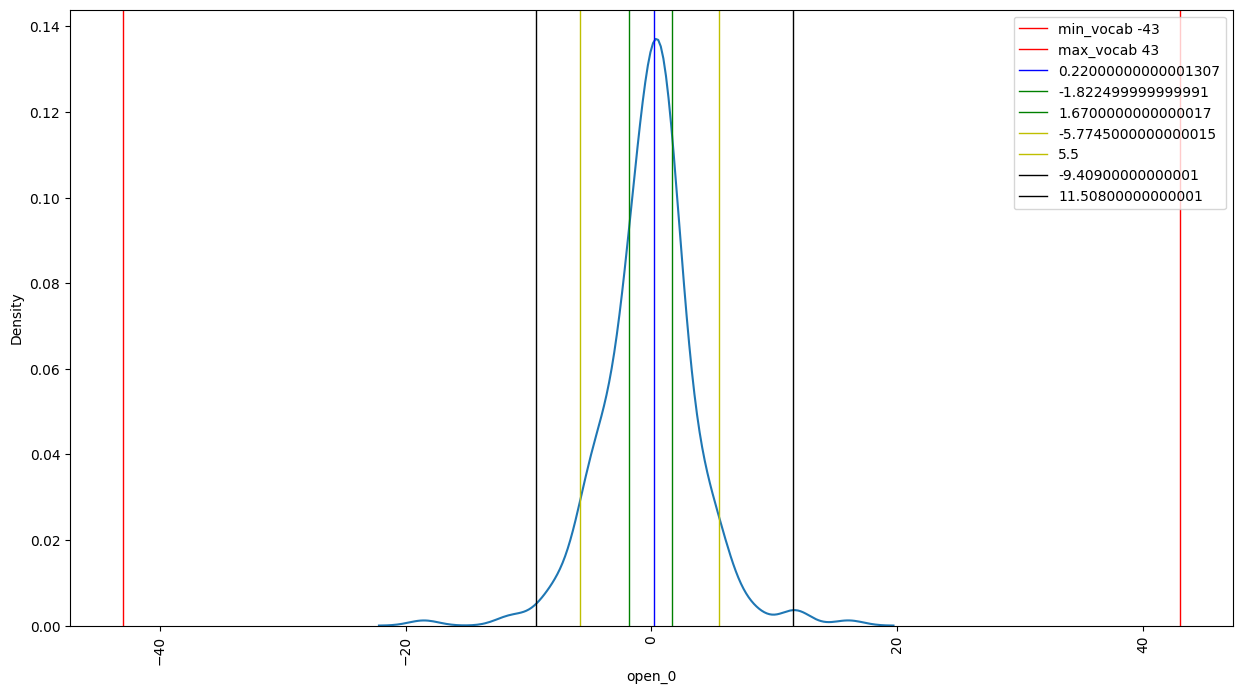

In [169]:
raw_val = open_df.open_0
sns.kdeplot(x=raw_val)
percentile_1, percentile_5, percentile_25, percentile_50, percentile_75, percentile_95, percentile_99 = np.percentile(raw_val, [1, 5, 25, 50, 75, 95, 99])
plt.xticks(rotation=90)
plt.axvline(-43,linewidth=1, color='r', label='min_vocab -43')
plt.axvline(43,linewidth=1, color='r', label='max_vocab 43')
plt.axvline(percentile_50,linewidth=1, color='b', label=percentile_50)
[plt.axvline(_x, linewidth=1, color='g', label=_x) for _x in [percentile_25, percentile_75]]
[plt.axvline(_x, linewidth=1, color='y', label=_x) for _x in [percentile_5, percentile_95]]
[plt.axvline(_x, linewidth=1, color='k', label=_x) for _x in [percentile_1, percentile_99]]
plt.legend()
plt.show()

In [170]:
for i in np.arange(MAX_LEN,0,-1):
  open_df.insert(loc=int(MAX_LEN-i),column='open_'+str(i),value=open_df.open_0.shift(i))

In [171]:
open_df.head(3)

,open_128,open_127,open_126,open_125,open_124,open_123,open_122,open_121,open_120,open_119,...,open_9,open_8,open_7,open_6,open_5,open_4,open_3,open_2,open_1,open_0
mTIMESTAMP,,,,,,,,,,,,,,,,,,,,,
30-Jan-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.7
31-Jan-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.7,-0.6
01-Feb-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.7,-0.6,0.7


In [172]:
open_df.tail(3)

,open_128,open_127,open_126,open_125,open_124,open_123,open_122,open_121,open_120,open_119,...,open_9,open_8,open_7,open_6,open_5,open_4,open_3,open_2,open_1,open_0
mTIMESTAMP,,,,,,,,,,,,,,,,,,,,,
25-Feb-2025,0.40,-1.20,0.45,0.64,4.11,1.25,-0.65,-1.60,1.65,2.44,...,-2.49,0.31,-0.50,-3.25,1.20,-0.34,1.73,2.16,-1.75,-0.03
27-Feb-2025,-1.20,0.45,0.64,4.11,1.25,-0.65,-1.60,1.65,2.44,-5.59,...,0.31,-0.50,-3.25,1.20,-0.34,1.73,2.16,-1.75,-0.03,-1.96
28-Feb-2025,0.45,0.64,4.11,1.25,-0.65,-1.60,1.65,2.44,-5.59,0.61,...,-0.50,-3.25,1.20,-0.34,1.73,2.16,-1.75,-0.03,-1.96,-2.26


In [173]:
open_df.dropna(inplace=True)

In [174]:
open_df[open_df['open_0'].isnull()==True].count().sum()

0

In [175]:
open_df.shape

(144, 129)

In [176]:
open_df.tail(3)

,open_128,open_127,open_126,open_125,open_124,open_123,open_122,open_121,open_120,open_119,...,open_9,open_8,open_7,open_6,open_5,open_4,open_3,open_2,open_1,open_0
mTIMESTAMP,,,,,,,,,,,,,,,,,,,,,
25-Feb-2025,0.40,-1.20,0.45,0.64,4.11,1.25,-0.65,-1.60,1.65,2.44,...,-2.49,0.31,-0.50,-3.25,1.20,-0.34,1.73,2.16,-1.75,-0.03
27-Feb-2025,-1.20,0.45,0.64,4.11,1.25,-0.65,-1.60,1.65,2.44,-5.59,...,0.31,-0.50,-3.25,1.20,-0.34,1.73,2.16,-1.75,-0.03,-1.96
28-Feb-2025,0.45,0.64,4.11,1.25,-0.65,-1.60,1.65,2.44,-5.59,0.61,...,-0.50,-3.25,1.20,-0.34,1.73,2.16,-1.75,-0.03,-1.96,-2.26


In [177]:
# Remove the outliers

#count = 0
open_matrix_reduced = []
for i in open_df.values:
  reduced_arr_open = []
  for j in i:
    if (j >= 43):
      reduced_arr_open.append(43)
    elif (j <= -43):
      reduced_arr_open.append(-43)
    else:
      reduced_arr_open.append(j)
  #count+=1
  #print(count)
  open_matrix_reduced.append(reduced_arr_open)

#print(tok_matrix)
#data_df_token = pd.concat([data_df_token,pd.DataFrame(tok_arr)],ignore_index=True)

In [178]:
open_df_reduced = pd.DataFrame(open_matrix_reduced)
open_df_reduced.shape

(144, 129)

#### Hign

In [179]:
high_df = pd.DataFrame(data=data_df_select.high_chg)
high_df.rename(columns={'high_chg':'high_0'},inplace=True)
high_df.head()

,high_0
mTIMESTAMP,
30-Jan-2024,3.8
31-Jan-2024,-2.1
01-Feb-2024,0.6
02-Feb-2024,16.1
05-Feb-2024,10.4


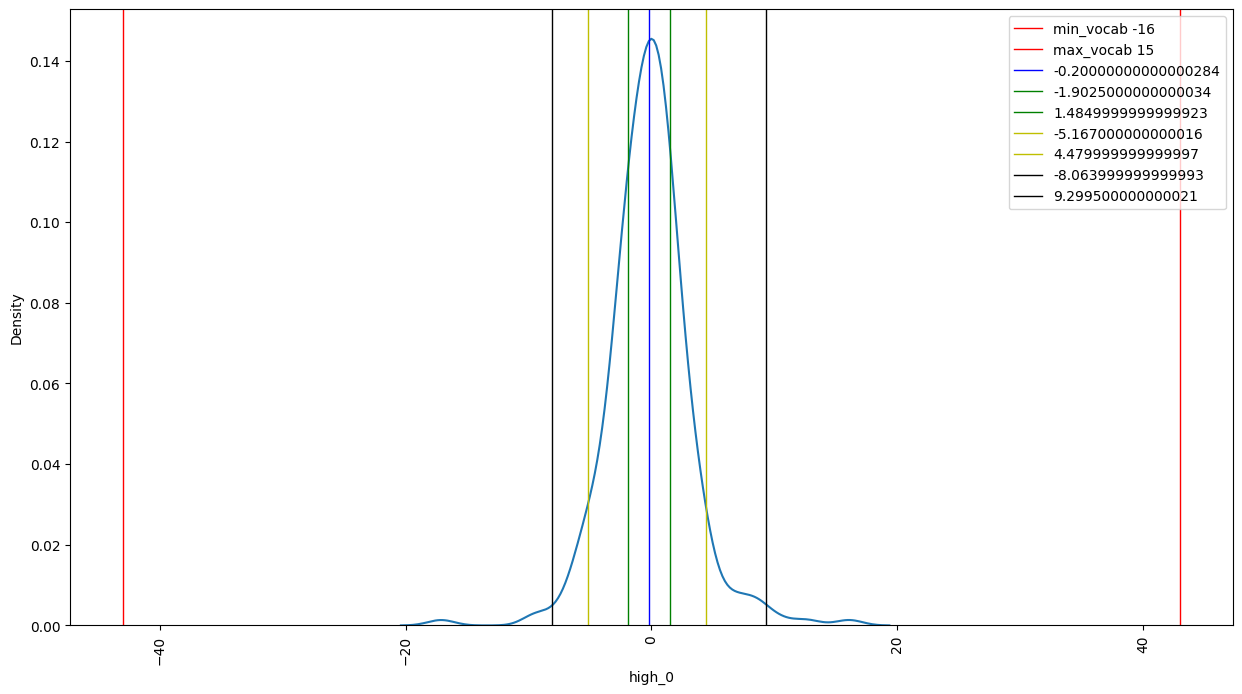

In [180]:
raw_val = high_df.high_0
sns.kdeplot(x=raw_val)
percentile_1, percentile_5, percentile_25, percentile_50, percentile_75, percentile_95, percentile_99 = np.percentile(raw_val, [1, 5, 25, 50, 75, 95, 99])
plt.xticks(rotation=90)
plt.axvline(-43,linewidth=1, color='r', label='min_vocab -16')
plt.axvline(43,linewidth=1, color='r', label='max_vocab 15')
plt.axvline(percentile_50,linewidth=1, color='b', label=percentile_50)
[plt.axvline(_x, linewidth=1, color='g', label=_x) for _x in [percentile_25, percentile_75]]
[plt.axvline(_x, linewidth=1, color='y', label=_x) for _x in [percentile_5, percentile_95]]
[plt.axvline(_x, linewidth=1, color='k', label=_x) for _x in [percentile_1, percentile_99]]
plt.legend()
plt.show()

In [181]:
for i in np.arange(MAX_LEN,0,-1):
  high_df.insert(loc=int(MAX_LEN-i),column='high_'+str(i),value=high_df.high_0.shift(i))

In [182]:
high_df.head()

,high_128,high_127,high_126,high_125,high_124,high_123,high_122,high_121,high_120,high_119,...,high_9,high_8,high_7,high_6,high_5,high_4,high_3,high_2,high_1,high_0
mTIMESTAMP,,,,,,,,,,,,,,,,,,,,,
30-Jan-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8
31-Jan-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,-2.1
01-Feb-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,-2.1,0.6
02-Feb-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.8,-2.1,0.6,16.1
05-Feb-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.8,-2.1,0.6,16.1,10.4


In [183]:
high_df.dropna(inplace=True)

In [184]:
high_df[high_df['high_0'].isnull()==True].count().sum()

0

In [185]:
high_df.tail(3)

,high_128,high_127,high_126,high_125,high_124,high_123,high_122,high_121,high_120,high_119,...,high_9,high_8,high_7,high_6,high_5,high_4,high_3,high_2,high_1,high_0
mTIMESTAMP,,,,,,,,,,,,,,,,,,,,,
25-Feb-2025,-1.12,0.26,1.87,0.80,1.48,2.42,-2.29,0.79,4.30,-2.71,...,-2.54,0.80,-0.76,-2.44,0.45,0.92,2.78,0.76,-2.40,-0.60
27-Feb-2025,0.26,1.87,0.80,1.48,2.42,-2.29,0.79,4.30,-2.71,-4.08,...,0.80,-0.76,-2.44,0.45,0.92,2.78,0.76,-2.40,-0.60,-1.71
28-Feb-2025,1.87,0.80,1.48,2.42,-2.29,0.79,4.30,-2.71,-4.08,-0.47,...,-0.76,-2.44,0.45,0.92,2.78,0.76,-2.40,-0.60,-1.71,-2.79


In [186]:
# Remove the outliers

#count = 0
high_matrix_reduced = []
for i in high_df.values:
  reduced_arr_high = []
  for j in i:
    if (j >= 43):
      reduced_arr_high.append(43)
    elif (j <= -43):
      reduced_arr_high.append(-43)
    else:
      reduced_arr_high.append(j)
  #count+=1
  #print(count)
  high_matrix_reduced.append(reduced_arr_high)

#print(tok_matrix)
#data_df_token = pd.concat([data_df_token,pd.DataFrame(tok_arr)],ignore_index=True)

In [187]:
high_df_reduced = pd.DataFrame(high_matrix_reduced)
high_df_reduced.shape

(144, 129)

#### Low

In [188]:
low_df = pd.DataFrame(data=data_df_select.low_chg)
low_df.rename(columns={'low_chg':'low_0'},inplace=True)
low_df.head()

,low_0
mTIMESTAMP,
30-Jan-2024,3.00
31-Jan-2024,-0.40
01-Feb-2024,0.95
02-Feb-2024,4.00
05-Feb-2024,13.65


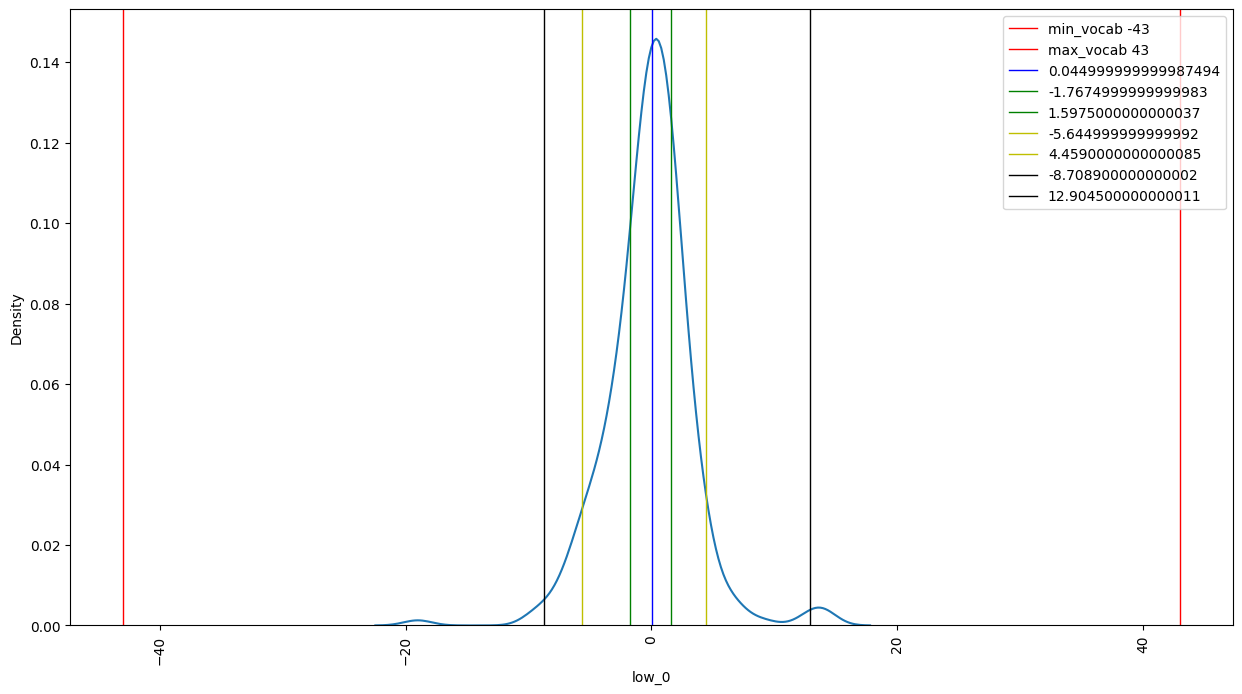

In [189]:
raw_val = low_df.low_0
sns.kdeplot(x=raw_val)
percentile_1, percentile_5, percentile_25, percentile_50, percentile_75, percentile_95, percentile_99 = np.percentile(raw_val, [1, 5, 25, 50, 75, 95, 99])
plt.xticks(rotation=90)
plt.axvline(-43,linewidth=1, color='r', label='min_vocab -43')
plt.axvline(43,linewidth=1, color='r', label='max_vocab 43')
plt.axvline(percentile_50,linewidth=1, color='b', label=percentile_50)
[plt.axvline(_x, linewidth=1, color='g', label=_x) for _x in [percentile_25, percentile_75]]
[plt.axvline(_x, linewidth=1, color='y', label=_x) for _x in [percentile_5, percentile_95]]
[plt.axvline(_x, linewidth=1, color='k', label=_x) for _x in [percentile_1, percentile_99]]
plt.legend()
plt.show()

In [190]:
for i in np.arange(MAX_LEN,0,-1):
  low_df.insert(loc=int(MAX_LEN-i),column='low_'+str(i),value=low_df.low_0.shift(i))

In [191]:
low_df.head()

,low_128,low_127,low_126,low_125,low_124,low_123,low_122,low_121,low_120,low_119,...,low_9,low_8,low_7,low_6,low_5,low_4,low_3,low_2,low_1,low_0
mTIMESTAMP,,,,,,,,,,,,,,,,,,,,,
30-Jan-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00
31-Jan-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,-0.40
01-Feb-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,-0.40,0.95
02-Feb-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,-0.40,0.95,4.00
05-Feb-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,-0.4,0.95,4.00,13.65


In [192]:
low_df.dropna(inplace=True)

In [193]:
low_df[low_df['low_0'].isnull()==True].count().sum()

0

In [194]:
low_df.tail(3)

,low_128,low_127,low_126,low_125,low_124,low_123,low_122,low_121,low_120,low_119,...,low_9,low_8,low_7,low_6,low_5,low_4,low_3,low_2,low_1,low_0
mTIMESTAMP,,,,,,,,,,,,,,,,,,,,,
25-Feb-2025,-0.27,-0.65,1.48,-0.07,2.96,0.89,-1.41,0.51,1.80,-3.21,...,-2.72,2.67,-3.95,-1.60,1.91,1.59,1.08,1.85,-1.43,-1.00
27-Feb-2025,-0.65,1.48,-0.07,2.96,0.89,-1.41,0.51,1.80,-3.21,-1.05,...,2.67,-3.95,-1.60,1.91,1.59,1.08,1.85,-1.43,-1.00,-2.31
28-Feb-2025,1.48,-0.07,2.96,0.89,-1.41,0.51,1.80,-3.21,-1.05,0.90,...,-3.95,-1.60,1.91,1.59,1.08,1.85,-1.43,-1.00,-2.31,-3.17


In [195]:
# Remove the outliers

#count = 0
low_matrix_reduced = []
for i in low_df.values:
  reduced_arr_low = []
  for j in i:
    if (j >= 43):
      reduced_arr_low.append(43)
    elif (j <= -43):
      reduced_arr_low.append(-43)
    else:
      reduced_arr_low.append(j)
  #count+=1
  #print(count)
  low_matrix_reduced.append(reduced_arr_low)

#print(tok_matrix)
#data_df_token = pd.concat([data_df_token,pd.DataFrame(tok_arr)],ignore_index=True)

In [196]:
low_df_reduced = pd.DataFrame(low_matrix_reduced)
low_df_reduced.shape

(144, 129)

#### Close

In [197]:
close_df = pd.DataFrame(data=data_df_select.close_chg)
close_df.rename(columns={'close_chg':'close_0'},inplace=True)
close_df.tail()

,close_0
mTIMESTAMP,
21-Feb-2025,-1.08
24-Feb-2025,-1.39
25-Feb-2025,-1.73
27-Feb-2025,-2.47
28-Feb-2025,-2.23


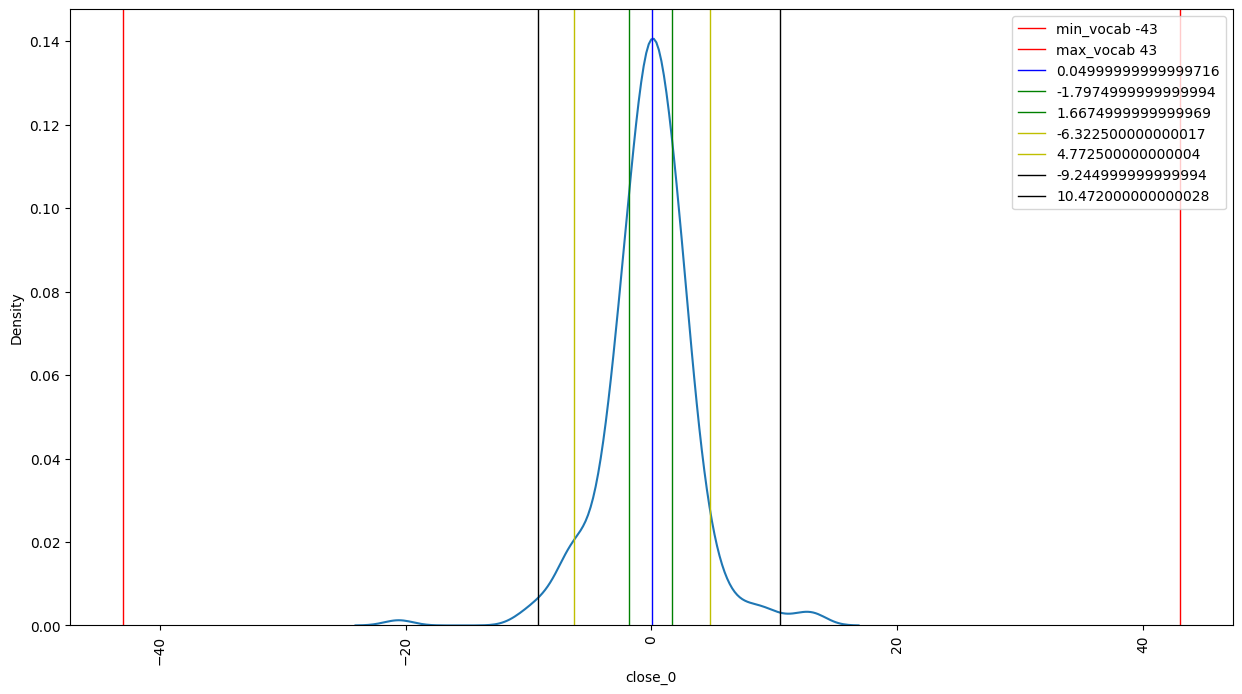

In [198]:
raw_val = close_df.close_0
sns.kdeplot(x=raw_val)
percentile_1, percentile_5, percentile_25, percentile_50, percentile_75, percentile_95, percentile_99 = np.percentile(raw_val, [1, 5, 25, 50, 75, 95, 99])
plt.xticks(rotation=90)
plt.axvline(-43,linewidth=1, color='r', label='min_vocab -43')
plt.axvline(43,linewidth=1, color='r', label='max_vocab 43')
plt.axvline(percentile_50,linewidth=1, color='b', label=percentile_50)
[plt.axvline(_x, linewidth=1, color='g', label=_x) for _x in [percentile_25, percentile_75]]
[plt.axvline(_x, linewidth=1, color='y', label=_x) for _x in [percentile_5, percentile_95]]
[plt.axvline(_x, linewidth=1, color='k', label=_x) for _x in [percentile_1, percentile_99]]
plt.legend()
plt.show()

In [199]:
for i in np.arange(MAX_LEN,0,-1):
  close_df.insert(loc=int(MAX_LEN-i),column='close_'+str(i),value=close_df.close_0.shift(i))

In [200]:
close_df.head()

,close_128,close_127,close_126,close_125,close_124,close_123,close_122,close_121,close_120,close_119,...,close_9,close_8,close_7,close_6,close_5,close_4,close_3,close_2,close_1,close_0
mTIMESTAMP,,,,,,,,,,,,,,,,,,,,,
30-Jan-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05
31-Jan-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05,-0.85
01-Feb-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05,-0.85,2.65
02-Feb-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.05,-0.85,2.65,13.35
05-Feb-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.05,-0.85,2.65,13.35,11.75


In [201]:
close_df.dropna(inplace=True)

In [202]:
close_df[close_df['close_0'].isnull()==True].count().sum()

0

In [203]:
close_df.tail(3)

,close_128,close_127,close_126,close_125,close_124,close_123,close_122,close_121,close_120,close_119,...,close_9,close_8,close_7,close_6,close_5,close_4,close_3,close_2,close_1,close_0
mTIMESTAMP,,,,,,,,,,,,,,,,,,,,,
25-Feb-2025,0.26,-0.29,0.59,2.97,0.05,1.55,-2.36,1.21,3.54,-4.16,...,0.26,-0.80,-2.88,1.48,0.06,1.29,2.82,-1.08,-1.39,-1.73
27-Feb-2025,-0.29,0.59,2.97,0.05,1.55,-2.36,1.21,3.54,-4.16,-1.18,...,-0.80,-2.88,1.48,0.06,1.29,2.82,-1.08,-1.39,-1.73,-2.47
28-Feb-2025,0.59,2.97,0.05,1.55,-2.36,1.21,3.54,-4.16,-1.18,0.11,...,-2.88,1.48,0.06,1.29,2.82,-1.08,-1.39,-1.73,-2.47,-2.23


In [204]:
# Remove the outliers

#count = 0
close_matrix_reduced = []
for i in close_df.values:
  reduced_arr_close = []
  for j in i:
    if (j >= 43):
      reduced_arr_close.append(43)
    elif (j <= -43):
      reduced_arr_close.append(-43)
    else:
      reduced_arr_close.append(j)
  #count+=1
  #print(count)
  close_matrix_reduced.append(reduced_arr_close)

#print(tok_matrix)
#data_df_token = pd.concat([data_df_token,pd.DataFrame(tok_arr)],ignore_index=True)

close_df_reduced = pd.DataFrame(close_matrix_reduced)
close_df_reduced.shape

(144, 129)

### Features and Target split

In [205]:
inp_len=128

In [206]:
open_df_reduced.shape

(144, 129)

In [207]:
high_df_reduced.shape

(144, 129)

In [208]:
low_df_reduced.shape

(144, 129)

In [209]:
close_df_reduced.shape

(144, 129)

In [210]:
feature_cols = open_df_reduced.columns[:inp_len].values
target_cols = open_df_reduced.columns[inp_len:].values

X_open = open_df_reduced.drop(columns=target_cols).values
y_open = open_df_reduced.drop(columns=feature_cols).values

X_high = high_df_reduced.drop(columns=target_cols).values
y_high = high_df_reduced.drop(columns=feature_cols).values

X_low = low_df_reduced.drop(columns=target_cols).values
y_low = low_df_reduced.drop(columns=feature_cols).values

X_close = close_df_reduced.drop(columns=target_cols).values
y_close = close_df_reduced.drop(columns=feature_cols).values

In [211]:
X_open_f = X_open.astype(np.float32)
y_open_t = tf.convert_to_tensor(y_open)

X_high_f = X_high.astype(np.float32)
y_high_t = tf.convert_to_tensor(y_high)

X_low_f = X_low.astype(np.float32)
y_low_t = tf.convert_to_tensor(y_low)

X_close_f = X_close.astype(np.float32)
y_close_t = tf.convert_to_tensor(y_close)

In [212]:
print('X Open shape',X_open_f.shape)
print('Y Open shape',y_open_t.shape)

print('X High shape',X_high_f.shape)
print('Y High shape',y_high_t.shape)

print('X Low shape',X_low_f.shape)
print('Y Low shape',y_low_t.shape)

print('X Close shape',X_close_f.shape)
print('Y Close shape',y_close_t.shape)

X Open shape (144, 128)
Y Open shape (144, 1)
X High shape (144, 128)
Y High shape (144, 1)
X Low shape (144, 128)
Y Low shape (144, 1)
X Close shape (144, 128)
Y Close shape (144, 1)


# Model Architecture <br>
* The querys is what you're trying to find.
* The keys what sort of information the dictionary has.
* The value is that information.


<b>fft_length and frame_length</b>
* The number of frequency bins depends on the FFT size (fft_length), which is often set to the next power of 2 that is greater than or equal to frame_length
* example, if frame_lenght = 39, Next power of 2 greater than 39 is 64. Setting fft_length = 64 would allow the FFT algorithm to work more efficiently by padding the input to a length of 64.
* or choose frame_lenght any of 2, 4, 8, 16, 32, 64, ... <br>

<b>frame_step</b>
* To choose frame_step, 50% Overlap (a common choice): To achieve 50% overlap, set frame_step to half the frame_length: frame_step = frame_length/2
* example, if frame_length=8, then frame_step=8/2 = 4. This will give you overlapping frames, which improves frequency resolution.<br>

<b>Frequency_bins v/s time_bins</b>
*  have more Frequency_bins if identifying a long-term uptrend or downtrend based on weekly or monthly stock price data, or detecting cyclic behavior like seasonality.
* have more time_bins if Detecting intraday trends or anomalies (like a sudden price surge due to a news release).

### The Fourier Transform layer

The output is a 2D array of shape (n_freqs, n_times), where n_freqs is the number of frequency bins (same as the length of f), and n_times is the number of time segments (same as the length of t).
* Rows of Zxx correspond to different frequencies (i.e., values in the f array).
* Columns of Zxx correspond to different time segments (i.e., values in the t array).
* The magnitude of the complex numbers in Zxx (np.abs(Zxx)) represents the strength or amplitude of each frequency component at that time segment.
* The phase of the complex numbers in Zxx (np.angle(Zxx)) represents the phase information of the signal at that frequency and time.
*  A larger window (windows_size, hops) gives better frequency resolution but poorer time resolution. You may need to experiment with different values based on your data.

* When saving a model that includes custom objects, such as a subclassed Layer, you must define a get_config() method on the object class.
* If the arguments passed to the constructor (`__init__()` method) of the custom object aren't Python objects (anything other than base types like ints, strings, etc.), then you must also explicitly deserialize these arguments in the from_config() class method.
* Calling `model.get_config()` or `layer.get_config()` will return a Python dict containing
the configuration of the model or layer, respectively. You should define `get_config()`
to contain arguments needed for the `__init__()` method of the model or layer. At loading time,
the `from_config(config)` method will then call `__init__()` with these arguments to
reconstruct the model or layer.
* Upon registration, you can optionally specify a package or a name. If left blank, the package defaults to `Custom` and the name defaults to the class name.
* In Python, using * as a parameter in a function or method signature (like def `__init__(self, *, signal_length, frame_length, frame_step)`) enforces keyword-only arguments for any parameters that come after the *. This means that signal_length, frame_length, and frame_step must be passed by name, rather than by position, when you create an instance of the FourierTransform class.

* tf.py_function allows TensorFlow to execute scipy_stft_fn, passing a tensor as input, converting it to a NumPy array internally, and returning a tensor that is compatible with TensorFlow.
* In the build method of the FourierTransform class, the shape of self.kernel should be a tuple, but it is set as a single value (self.windows_size). self.windows_size should be wrapped in parentheses to specify the shape correctly, assuming it's a 1D kernel.

In [228]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class FourierTransform(Layer):
  def __init__(self, *, signal_length, frame_length, frame_step):
    super().__init__()
    self.signal_length = signal_length
    self.frame_length = frame_length
    self.frame_step = frame_step

    self.spectrogram = tf.Variable(trainable=True,
                                   initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))
    self.magnitude_x = tf.Variable(trainable=True,
                                   initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))
    self.angle_x = tf.Variable(trainable=True,
                               initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))

  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.signal_length,), # the use of ',' after self.signal_len is a must, read the above mentioned comments point-2
  #      initializer=initializer_for_relu,
  #      trainable=False
  #  )

  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
            "signal_length": self.signal_length,
            "frame_length": self.frame_length,
            "frame_step": self.frame_step,
        }
      )
    return config

  def call(self, x):
    # window_gen = hann_window(self.windows_size)  # symmetric Gaussian window
    # Convert the waveform to a spectrogram via a STFT.
    self.spectrogram = tf.signal.stft(signals=x, frame_length=self.frame_length, frame_step=self.frame_step)
    self.magnitude_x = tf.math.abs(self.spectrogram)
    self.angle_x = tf.math.angle(self.spectrogram) # Disable it if using only magnitude as output
    #magnitude_x = tf_round(magnitude_x, 4)
    #angle_x = tf_round(angle_x, 4) # Disable it if using only magnitude as output
    return self.magnitude_x , self.angle_x

### Self-attention layer - Magnitude and Angle

* tf.ensure_shape Updates the shape of a tensor and checks at runtime that the shape holds.
* When executed, this operation asserts that the input tensor x's shape is compatible with the shape argument.

In [229]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class SelfAttention(Layer):
  def __init__(self, frequency_bins, time_bins, regularizer_rate, num_heads, dropout_rate=0.1, **kwargs):
    # Call the parent class (BaseAttention) constructor
    super().__init__(**kwargs)
    self.frequency_bins = frequency_bins
    self.time_bins = time_bins
    self.regularizer_rate = regularizer_rate
    self.num_heads = num_heads

    self.mha = MultiHeadAttention(key_dim = frequency_bins,
                                  kernel_initializer = initializer_for_relu,
                                  num_heads = num_heads,
                                  dropout=dropout_rate,
                                  kernel_regularizer=l2(regularizer_rate),
                                  bias_regularizer=l2(regularizer_rate),
                                  activity_regularizer=l2(regularizer_rate)
                                  )
    self.layernorm = LayerNormalization(beta_initializer='zeros', gamma_initializer='ones',
                                      beta_regularizer=l2(regularizer_rate), gamma_regularizer=l2(regularizer_rate))
    self.add = Add()

    self.attn_output = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))
    self.add_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))
    self.norm_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))

  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
    #        "mha": self.mha,
    #        "layernorm": self.layernorm,
    #        "add": self.add,

            "frequency_bins": self.frequency_bins,
            "time_bins": self.time_bins,
            "regularizer_rate": self.regularizer_rate,
            "num_heads": self.num_heads,
        }
      )
    return config

  '''
  @classmethod
  #def from_config(cls, config):
  #    config["mha"] = keras.layers.deserialize(config["mha"])
  #    config["layernorm"] = keras.layers.deserialize(config["layernorm"])
  #    config["add"] = keras.layers.deserialize(config["add"])
  #    return cls(**config)

  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.time_bins, self.frequency_bins),
  #      initializer=initializer_for_relu,
  #      trainable=True
  #  )
  '''

  def call(self, magnitude):
    magnitude = tf.ensure_shape(magnitude, [None, self.time_bins, self.frequency_bins])
    self.attn_output = self.mha( query=magnitude,  # The querys is what you're trying to find.
                                 key=magnitude,  # The keys what sort of information the dictionary has.
                                 value=magnitude # The value is that information.
                                 )
    # Cache the attention scores for plotting later.
    #self.last_attn_scores = attn_scores

    self.add_out = self.add([magnitude, self.attn_output])
    self.norm_out = self.layernorm(self.add_out)
    #x = tf_round(x, 4)
    return self.norm_out

### The global cross-attention layer

The similarity (or dot product) between the Query and each Key is computed to determine an attention score. These scores measure how relevant each item (Key) is to the current item (Query).

In [230]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class GlobalCrossAttention(Layer):
  def __init__(self, *, frequency_bins, time_bins, regularizer_rate, num_heads, dropout_rate=0.1, **kwargs):
      # Call the parent class (BaseAttention) constructor
      super().__init__(**kwargs)
      self.frequency_bins = frequency_bins
      self.time_bins = time_bins
      self.regularizer_rate = regularizer_rate
      self.num_heads = num_heads
      self.mha = MultiHeadAttention(key_dim = frequency_bins,
                              kernel_initializer = initializer_for_relu,
                              num_heads = num_heads,
                              dropout=dropout_rate,
                              kernel_regularizer=l2(regularizer_rate),
                              bias_regularizer=l2(regularizer_rate),
                              activity_regularizer=l2(regularizer_rate)
                              )
      self.layernorm = LayerNormalization(beta_initializer='zeros', gamma_initializer='ones',
                                        beta_regularizer=l2(regularizer_rate), gamma_regularizer=l2(regularizer_rate))
      self.add = Add()

      self.attn_output = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))
      self.add_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))
      self.norm_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))

  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
    #        "mha": self.mha,
    #        "layernorm": self.layernorm,
    #        "add": self.add,

            "frequency_bins": self.frequency_bins,
            "time_bins": self.time_bins,
            "regularizer_rate": self.regularizer_rate,
            "num_heads": self.num_heads,
        }
      )
    return config
  '''
  @classmethod
  def from_config(cls, config):
      # Note that you can also use `keras.saving.deserialize_keras_object` here
      #config["sft_layer"] = keras.layers.deserialize(config["sft_layer"])
      config["mha"] = keras.layers.deserialize(config["mha"])
      config["layernorm"] = keras.layers.deserialize(config["layernorm"])
      config["add"] = keras.layers.deserialize(config["add"])
      return cls(**config)
  '''
  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.time_bins, self.frequency_bins),
  #      initializer=initializer_for_relu,
  #      trainable=True
  #  )

  def call(self, magnitude, angle):
    magnitude = tf.ensure_shape(angle, [None, self.time_bins, self.frequency_bins])
    angle = tf.ensure_shape(angle, [None, self.time_bins, self.frequency_bins])
    #attn_output, attn_scores = self.mha(
    self.attn_output = self.mha( query=magnitude,  # The querys is what you're trying to find.
                                 key=angle,  # The keys what sort of information the dictionary has.
                                 value=angle, # The value is that information.
                                 return_attention_scores=False
                                 )

    # Cache the attention scores for plotting later.
    #self.last_attn_scores = attn_scores

    self.add_out = self.add([magnitude, self.attn_output])
    self.norm_out = self.layernorm(self.add_out)
    #x = tf_round(x, 4)
    return self.norm_out

### Gated - Feed Forward Network Layer

In [231]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class FeedForward(Layer):
  # dff - dence feed forward neurons
  # sft_len - output shape Fourier Transform
  def __init__(self, *, frequency_bins, time_bins, regularizer_rate, dropout_rate=0.1, **kwargs):
    super().__init__(**kwargs)
    self.frequency_bins = frequency_bins
    self.time_bins = time_bins
    self.regularizer_rate = regularizer_rate
    self.dropout_rate = dropout_rate

    self.seq = Sequential([

        #Dense(tf.get_static_value(tf.cast(frequency_bins*time_bins, dtype=tf.int32)),
        #      bias_initializer='zeros',
        #      kernel_regularizer=l2(regularizer_rate),
        #      bias_regularizer=l2(regularizer_rate),
        #      activity_regularizer=l2(regularizer_rate),
        #      activation='relu', kernel_initializer=initializer_for_relu),
        #Dropout(dropout_rate),

        Dense(tf.get_static_value(tf.cast(frequency_bins*time_bins, dtype=tf.int32)),
              bias_initializer='zeros',
              kernel_regularizer=l2(regularizer_rate),
              bias_regularizer=l2(regularizer_rate),
              activity_regularizer=l2(regularizer_rate),
              activation='tanh', kernel_initializer=initializer_for_sigmoid),
        Dropout(dropout_rate),

        Dense(tf.get_static_value(tf.cast(frequency_bins*time_bins/2, dtype=tf.int32)),
              bias_initializer='zeros',
              kernel_regularizer=l2(regularizer_rate),
              bias_regularizer=l2(regularizer_rate),
              activity_regularizer=l2(regularizer_rate),
              activation='tanh',
              kernel_initializer=initializer_for_sigmoid),
        Dropout(dropout_rate),

        Dense(frequency_bins,
              kernel_initializer=initializer_for_sigmoid,
              bias_initializer='zeros',
              kernel_regularizer=l2(regularizer_rate),
              bias_regularizer=l2(regularizer_rate),
              activity_regularizer=l2(regularizer_rate),
              activation='tanh'
              ) # NO Activation Function, to predict linear values as given in original paper
    ])
    #self.add = Add()
    self.multiply = Multiply()
    self.layer_norm = LayerNormalization(beta_initializer='zeros', gamma_initializer='ones',
                                        beta_regularizer=l2(regularizer_rate), gamma_regularizer=l2(regularizer_rate))

    self.ffn_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))

  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
    #        "multiply": self.multiply,
    #        "layer_norm": self.layer_norm,
    #        "seq":self.seq,

            "frequency_bins": self.frequency_bins,
            "time_bins": self.time_bins,
            "regularizer_rate": self.regularizer_rate,
        }
      )
    return config

  '''
  @classmethod
  def from_config(cls, config):
      # Note that you can also use `keras.saving.deserialize_keras_object` here
      config["multiply"] = keras.layers.deserialize(config["multiply"])
      config["layer_norm"] = keras.layers.deserialize(config["layer_norm"])
      config["seq"] = keras.layers.deserialize(config["seq"])
      return cls(**config)
  '''
  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.time_bins, self.frequency_bins),
  #      initializer=initializer_for_relu,
  #      trainable=True
  #  )

  def call(self, x):
    self.ffn_out = self.multiply([x, self.seq(x)])
    self.ffn_out = self.layer_norm(self.ffn_out)
    return self.ffn_out

### Complete Encoder Layer

In [232]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class EncoderLayer(Layer):
  def __init__(self,*, frequency_bins, time_bins, num_heads, dropout_rate, regularizer_rate, **kwargs):
    super().__init__(**kwargs)
    self.frequency_bins = frequency_bins
    self.time_bins = time_bins
    self.num_heads = num_heads
    self.regularizer_rate = regularizer_rate
    self.dropout_rate = dropout_rate

    self.self_attention = SelfAttention(frequency_bins=frequency_bins,
                                        time_bins=time_bins,
                                        regularizer_rate=regularizer_rate,
                                        num_heads=num_heads,
                                        dropout_rate=dropout_rate
                                        )

    self.ffn = FeedForward(frequency_bins=frequency_bins, time_bins=time_bins, regularizer_rate=regularizer_rate, dropout_rate=dropout_rate)

    self.enc_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))

  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
    #        "self_attention": self.self_attention,
    #        "ffn": self.ffn,

            "frequency_bins": self.frequency_bins,
            "time_bins": self.time_bins,
            "num_heads": self.num_heads,
            "regularizer_rate": self.regularizer_rate,
            "dropout_rate": self.dropout_rate,

        }
      )
    return config

  @classmethod
  def from_config(cls, config):
      # Note that you can also use `keras.saving.deserialize_keras_object` here
      config["self_attention"] = keras.layers.deserialize(config["self_attention"])
      config["ffn"] = keras.layers.deserialize(config["ffn"])
      return cls(**config)

  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.time_bins, self.frequency_bins),
  #      initializer=initializer_for_relu,
  #      trainable=True
  #  )

  def call(self, angle):
    self.enc_out = self.self_attention(angle)
    self.enc_out = self.ffn(self.enc_out)
    return self.enc_out

In [233]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class Encoder(Layer):
  def __init__(self, *, frequency_bins, time_bins, num_layers, num_heads, dropout_rate, regularizer_rate, **kwargs):
    super().__init__(**kwargs)

    self.frequency_bins = frequency_bins
    self.time_bins = time_bins
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.regularizer_rate = regularizer_rate
    self.dropout_rate = dropout_rate

    self.enc_layers = [ EncoderLayer(frequency_bins=frequency_bins,
                                     time_bins=time_bins,
                                     num_heads=num_heads,
                                     dropout_rate=dropout_rate,
                                     regularizer_rate=regularizer_rate
                                     ) for _ in range(num_layers)]

    self.enc_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))

  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
    #        "enc_layers": self.enc_layers,

            "frequency_bins": self.frequency_bins,
            "time_bins": self.time_bins,
            "num_layers": self.num_layers,
            "num_heads": self.num_heads,
            "regularizer_rate": self.regularizer_rate,
            "dropout_rate": self.dropout_rate,
        }
      )
    return config

  @classmethod
  def from_config(cls, config):
      # Note that you can also use `keras.saving.deserialize_keras_object` here
      config["enc_layers"] = keras.layers.deserialize(config["enc_layers"])
      return cls(**config)

  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.time_bins, self.frequency_bins),
  #      initializer=initializer_for_relu,
  #      trainable=True
  #  )

  def call(self, angle):
    for i in range(self.num_layers):
      self.enc_out = self.enc_layers[i](angle)
    #self.last_attn_scores = self.enc_layers[-1].last_attn_scores
    return self.enc_out


### Complete Decoder Layer

Each DecoderLayer containing a CausalSelfAttention, a CrossAttention, and a FeedForward layer:

In [234]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class DecoderLayer(Layer):
  def __init__(self, *, frequency_bins, time_bins, num_heads, dropout_rate, regularizer_rate, **kwargs):
    super().__init__(**kwargs)

    self.frequency_bins = frequency_bins
    self.time_bins = time_bins
    self.num_heads = num_heads
    self.regularizer_rate = regularizer_rate
    self.dropout_rate = dropout_rate

    self.local_self_att = SelfAttention(
        frequency_bins=frequency_bins,
        time_bins=time_bins,
        regularizer_rate=regularizer_rate,
        num_heads=num_heads,
        dropout_rate=dropout_rate
    )

    self.global_cross_att = GlobalCrossAttention(
        frequency_bins=frequency_bins,
        time_bins=time_bins,
        regularizer_rate=regularizer_rate,
        num_heads=num_heads,
        dropout_rate=dropout_rate
    )

    self.ffn = FeedForward(frequency_bins=frequency_bins,
                           time_bins=time_bins,
                           regularizer_rate=regularizer_rate,
                           dropout_rate=dropout_rate)

    self.self_att_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))
    self.cross_att_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))
    self.fnn_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))

  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
    #        "local_self_att": self.local_self_att,
    #        "global_cross_att": self.global_cross_att,
    #        "ffn": self.ffn,

            "frequency_bins": self.frequency_bins,
            "time_bins": self.time_bins,
            "num_heads": self.num_heads,
            "regularizer_rate": self.regularizer_rate,
            "dropout_rate": self.dropout_rate,
        }
      )
    return config

  @classmethod
  def from_config(cls, config):
      # Note that you can also use `keras.saving.deserialize_keras_object` here
      config["local_self_att"] = keras.layers.deserialize(config["local_self_att"])
      config["global_cross_att"] = keras.layers.deserialize(config["global_cross_att"])
      config["ffn"] = keras.layers.deserialize(config["ffn"])
      return cls(**config)

  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.time_bins, self.frequency_bins),
  #      initializer=initializer_for_relu,
  #      trainable=True
  #  )

  def call(self, magnitude, angle):
    self.self_att_out = self.local_self_att(magnitude)
    self.cross_att_out = self.global_cross_att(magnitude=magnitude, angle=self.self_att_out)

    # Cache the last attention scores for plotting later
    #self.last_attn_scores = self.global_cross_att.last_attn_scores

    self.fnn_out = self.ffn(self.cross_att_out)

    return self.fnn_out

In [235]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class Decoder(Layer):
  def __init__(self, *, frequency_bins, time_bins, num_heads, num_layers, regularizer_rate, dropout_rate=0.1, **kwargs):
    super().__init__(**kwargs)

    self.frequency_bins = frequency_bins
    self.time_bins = time_bins
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.regularizer_rate = regularizer_rate
    self.dropout_rate = dropout_rate

    self.decoder_layer = [ DecoderLayer(frequency_bins=frequency_bins,
                                        time_bins=time_bins,
                                        num_heads=num_heads,
                                        dropout_rate=dropout_rate,
                                        regularizer_rate=regularizer_rate
                                        ) for _ in range(num_layers)]

    self.decoder_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))

  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
   #         "decoder_layer": self.decoder_layer,

            "frequency_bins": self.frequency_bins,
            "time_bins": self.time_bins,
            "num_layers": self.num_layers,
            "num_heads": self.num_heads,
            "regularizer_rate": self.regularizer_rate,
            "dropout_rate": self.dropout_rate,
        }
      )
    return config

  @classmethod
  def from_config(cls, config):
      # Note that you can also use `keras.saving.deserialize_keras_object` here
      config["decoder_layer"] = keras.layers.deserialize(config["decoder_layer"])
      return cls(**config)

  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.time_bins, self.frequency_bins),
  #      initializer=initializer_for_relu,
  #      trainable=True
  #  )

  def call(self, magnitude, angle):
    for i in range(self.num_layers):
      self.decoder_out  = self.decoder_layer[i](magnitude, angle)
    #self.last_attn_scores = self.decoder_layer[-1].last_attn_scores
    return self.decoder_out

### Transformer

In [236]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class TransformerLayer(Layer):
  def __init__(self, *, signal_length, frame_length, frame_step,
               max_signal_length, min_signal_length,
               frequency_bins, time_bins,
               num_heads, num_layers, regularizer_rate, dropout_rate=0.1,
               **kwargs):
    super().__init__(**kwargs)

    self.signal_length = signal_length
    self.frame_length = frame_length
    self.frame_step = frame_step

    self.max_signal_length = max_signal_length
    self.min_signal_length = min_signal_length

    self.frequency_bins = frequency_bins
    self.time_bins = time_bins

    self.num_layers = num_layers
    self.num_heads = num_heads
    self.regularizer_rate = regularizer_rate
    self.dropout_rate = dropout_rate

    #self.time_bins = tf.cast(((signal_length - frame_length)/frame_step)+1 , dtype=tf.int32)
    #self.frequency_bins = tf.cast(tf.math.floor((frame_length/2) +1), dtype=tf.int32)
    self.filter_size = tf.cast(tf.math.floor(max_signal_length/2), dtype=tf.int32)

    self.sft_layer = FourierTransform(signal_length=signal_length,
                                      frame_length=frame_length,
                                      frame_step=frame_step)

    self.encoder = Encoder(frequency_bins=frequency_bins,
                           time_bins=time_bins,
                           num_layers=num_layers,
                           num_heads=num_heads,
                           dropout_rate=dropout_rate,
                           regularizer_rate=regularizer_rate)

    self.decoder = Decoder(frequency_bins=frequency_bins,
                           time_bins=time_bins,
                           num_layers=num_layers,
                           num_heads=num_heads,
                           dropout_rate=dropout_rate,
                           regularizer_rate=regularizer_rate)

    self.flatten_layer = Flatten()

    self.angle_x = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))
    self.magnitude_x = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))
    self.enc_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))
    self.dec_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))
    self.flat_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))


  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
            #"sft_layer": self.sft_layer,
            #"encoder": self.encoder,
            #"decoder": self.decoder,
            #"flatten_layer": self.flatten_layer,

            "signal_length": self.signal_length,
            "frame_length": self.frame_length,
            "frame_step": self.frame_step,

            "max_signal_length": self.max_signal_length,
            "min_signal_length": self.min_signal_length,

            "frequency_bins": self.frequency_bins,
            "time_bins": self.time_bins,

            "num_layers": self.num_layers,
            "num_heads": self.num_heads,
            "regularizer_rate": self.regularizer_rate,
            "dropout_rate": self.dropout_rate,
        }
      )
    return config


  @classmethod
  def from_config(cls, config):
      # Note that you can also use `keras.saving.deserialize_keras_object` here
      #config["sft_layer"] = keras.layers.deserialize(config["sft_layer"])
      config["encoder"] = keras.layers.deserialize(config["encoder"])
      config["decoder"] = keras.layers.deserialize(config["decoder"])
      config["flatten_layer"] = keras.layers.deserialize(config["flatten_layer"])
      return cls(**config)

  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.signal_length,),
  #      initializer=initializer_for_relu,
  #      trainable=True
  #  )

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the first argument.
    self.magnitude_x, self.angle_x = self.sft_layer(inputs)

    self.enc_out = self.encoder(self.angle_x)  # (batch_size, time_bins, frequency_bins)

    self.dec_out = self.decoder(self.magnitude_x, self.enc_out)  # (batch_size, time_bins, frequency_bins)

    # Final linear layer output.
    self.flat_out = self.flatten_layer(self.dec_out) # (batch_size, time_bins * frequency_bins)

    # Return the output.
    return self.flat_out

### Custom Gated Attention

In [237]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class GatedAttention(Layer):
  def __init__(self, units, regularizer_rate, **kwargs):
      super().__init__(**kwargs)

      self.units = units
      self.softmax = Softmax(axis=-1)
      self.query_dense = Dense(units,   # Project input to queries
                               activation='tanh',
                               bias_initializer='zeros',
                               kernel_regularizer=l2(regularizer_rate),
                               bias_regularizer=l2(regularizer_rate),
                               activity_regularizer=l2(regularizer_rate),
                               kernel_initializer=initializer_for_sigmoid)
      self.key_dense = Dense(units,   # Project input to keys
                               activation='tanh',
                               bias_initializer='zeros',
                               kernel_regularizer=l2(regularizer_rate),
                               bias_regularizer=l2(regularizer_rate),
                               activity_regularizer=l2(regularizer_rate),
                               kernel_initializer=initializer_for_sigmoid)
      self.value_dense = Dense(units,   # Project input to Value
                               activation='tanh',
                               bias_initializer='zeros',
                               kernel_regularizer=l2(regularizer_rate),
                               bias_regularizer=l2(regularizer_rate),
                               activity_regularizer=l2(regularizer_rate),
                               kernel_initializer=initializer_for_sigmoid)
      self.gate_dense = Dense(units, # Project input to gate values
                              activation='sigmoid',
                              bias_initializer='zeros',
                              kernel_regularizer=l2(regularizer_rate),
                              bias_regularizer=l2(regularizer_rate),
                              activity_regularizer=l2(regularizer_rate),
                              kernel_initializer=initializer_for_sigmoid)

      self.multiply = Multiply()
      self.layer_norm = LayerNormalization(beta_initializer='zeros', gamma_initializer='ones',
                                        beta_regularizer=l2(regularizer_rate), gamma_regularizer=l2(regularizer_rate))

      self.querry = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
      self.key = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
      self.value = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))

      self.attention_scores = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
      self.attention_weights = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
      self.attention_output = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))

      self.gate = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
      self.gated_attention_output = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
      self.gated_ln_output = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))

  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
            #"gate_dense": self.gate_dense,
            #"softmax": self.softmax,
            "units": self.units,
            "regularizer_rate": self.regularizer_rate,
        }
      )
    return config

  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.units,),
  #      initializer=initializer_for_relu,
  #      trainable=True
  #  )

  '''
  @classmethod
  def from_config(cls, config):
      # Note that you can also use `keras.saving.deserialize_keras_object` here
      config["gate_dense"] = keras.layers.deserialize(config["gate_dense"])
      config["softmax"] = keras.layers.deserialize(config["softmax"])
      return cls(**config)
  '''

  def call(self, magnitude):
      # Compute attention scores

      self.querry = self.query_dense(magnitude) # magnitude
      self.key = self.key_dense(magnitude) # magnitude
      self.value = self.value_dense(magnitude) # magnitude

      self.attention_scores = tf.matmul(self.querry, self.key, transpose_b=True) # Query, Key
      self.attention_scores /= tf.math.sqrt(tf.cast(tf.shape(self.key)[-1], tf.float32)) # Key
      #print('attention_scores out=',attention_scores.shape)

      # Softmax over the scores
      self.attention_weights = self.softmax(self.attention_scores)
      #print('attention_weights out=',attention_weights.shape)

      # Compute the attention output
      self.attention_output = tf.matmul(self.attention_weights, self.value) #Value
      #print('attention_output out=',attention_output.shape)

      # Compute the gate
      self.gate = self.gate_dense(magnitude)
      #print('gate_d_out out=',gate_d_out.shape)
      #self.gate = tf.math.sigmoid(self.gate) #Value # Gate is a function of the queries
      #print('gate out=',gate.shape)

      # Apply the gate to the attention output
      self.gated_attention_output = self.multiply([self.attention_output, self.gate])
      #self.gated_attention_output = self.attention_output * self.gate

      self.gated_ln_output = self.layer_norm(self.gated_attention_output)

      #print('gate gated_attention_output=',gate.shape)
      return self.gated_ln_output #, self.attention_weights

### Pre-Attention block - Feed forward network

In [238]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class PreAttFeedForward(Layer):
  # Purpose of this layer is to reduce the output shape
  # Input = (batch_size, frequency_bins*time_bins*parallel layers)
  # output = (batch_size, 1, feature_length) where feature_length can be min_signal_length or max_signal_length
  def __init__(self, units, regularizer_rate, dropout_rate=0.1, **kwargs):
    super().__init__(**kwargs)
    #self.seq = Sequential([
    #    Dense(1, activation='relu', kernel_initializer=initializer_for_relu),
    #    Dense(feature_length, activation='relu', kernel_initializer=initializer_for_relu),
    #    Dropout(dropout_rate)
    #])

    self.units = units
    self.dropout_rate = dropout_rate
    self.regularizer_rate = regularizer_rate

    #self.dense_sigmoid = Dense(units,
    #                          kernel_regularizer=l2(regularizer_rate),
    #                          bias_regularizer=l2(regularizer_rate),
    #                          activity_regularizer=l2(regularizer_rate),
    #                          activation='sigmoid', kernel_initializer=initializer_for_sigmoid
    #                          )

    #self.dense_relu = Dense(units,
    #                        kernel_regularizer=l2(regularizer_rate),
    #                        bias_regularizer=l2(regularizer_rate),
    #                        activity_regularizer=l2(regularizer_rate)
    #                        ,activation='relu', kernel_initializer=initializer_for_relu
    #                        )

    self.seq_sigmoid = Sequential([

        #Dense(tf.get_static_value(tf.cast(frequency_bins*time_bins, dtype=tf.int32)),
        #      bias_initializer='zeros',
        #      kernel_regularizer=l2(regularizer_rate),
        #      bias_regularizer=l2(regularizer_rate),
        #      activity_regularizer=l2(regularizer_rate),
        #      activation='relu', kernel_initializer=initializer_for_relu),
        #Dropout(dropout_rate),

        Dense(tf.get_static_value(tf.cast(units, dtype=tf.int32)),
              bias_initializer='zeros',
              kernel_regularizer=l2(regularizer_rate),
              bias_regularizer=l2(regularizer_rate),
              activity_regularizer=l2(regularizer_rate),
              activation='relu', kernel_initializer=initializer_for_relu),
        Dropout(dropout_rate),

        Dense(tf.get_static_value(tf.cast(units, dtype=tf.int32)),
              bias_initializer='zeros',
              kernel_regularizer=l2(regularizer_rate),
              bias_regularizer=l2(regularizer_rate),
              activity_regularizer=l2(regularizer_rate),
              activation='relu',
              kernel_initializer=initializer_for_relu),
        Dropout(dropout_rate),

        Dense(units,
              kernel_initializer=initializer_for_sigmoid,
              bias_initializer='zeros',
              kernel_regularizer=l2(regularizer_rate),
              bias_regularizer=l2(regularizer_rate),
              activity_regularizer=l2(regularizer_rate),
              activation='sigmoid'
              ) # NO Activation Function, to predict linear values as given in original paper
      ])

    self.seq_relu = Sequential([

        #Dense(tf.get_static_value(tf.cast(frequency_bins*time_bins, dtype=tf.int32)),
        #      bias_initializer='zeros',
        #      kernel_regularizer=l2(regularizer_rate),
        #      bias_regularizer=l2(regularizer_rate),
        #      activity_regularizer=l2(regularizer_rate),
        #      activation='relu', kernel_initializer=initializer_for_relu),
        #Dropout(dropout_rate),

        Dense(tf.get_static_value(tf.cast(units, dtype=tf.int32)),
              bias_initializer='zeros',
              kernel_regularizer=l2(regularizer_rate),
              bias_regularizer=l2(regularizer_rate),
              activity_regularizer=l2(regularizer_rate),
              activation='relu', kernel_initializer=initializer_for_relu),
        Dropout(dropout_rate),

        Dense(tf.get_static_value(tf.cast(units, dtype=tf.int32)),
              bias_initializer='zeros',
              kernel_regularizer=l2(regularizer_rate),
              bias_regularizer=l2(regularizer_rate),
              activity_regularizer=l2(regularizer_rate),
              activation='relu',
              kernel_initializer=initializer_for_relu),
        Dropout(dropout_rate),

        Dense(units,
              kernel_initializer=initializer_for_sigmoid,
              bias_initializer='zeros',
              kernel_regularizer=l2(regularizer_rate),
              bias_regularizer=l2(regularizer_rate),
              activity_regularizer=l2(regularizer_rate),
              activation='relu'
              ) # NO Activation Function, to predict linear values as given in original paper
      ])
    self.multiply = Multiply()
    self.dropout_layer = Dropout(dropout_rate)
    self.layer_norm = LayerNormalization(beta_initializer='zeros', gamma_initializer='ones',
                                        beta_regularizer=l2(regularizer_rate), gamma_regularizer=l2(regularizer_rate))

    self.gate_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
    self.ln_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))

  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
            #"dense_sigmoid": self.dense_sigmoid,
            #"dense_relu": self.dense_relu,
            #"seq_sigmoid": self.seq_sigmoid,
            #"seq_relu": self.seq_relu,
            #"multiply": self.multiply,
            #"dropout_layer": self.dropout_layer,
            #"layer_norm": self.layer_norm,
            "units": self.units,
            "regularizer_rate": self.regularizer_rate,
        }
      )
    return config


  @classmethod
  def from_config(cls, config):
      # Note that you can also use `keras.saving.deserialize_keras_object` here
      #config["dense_sigmoid"] = keras.layers.deserialize(config["dense_sigmoid"])
      #config["dense_relu"] = keras.layers.deserialize(config["dense_relu"])
      config["seq_sigmoid"] = keras.layers.deserialize(config["seq_sigmoid"])
      config["seq_relu"] = keras.layers.deserialize(config["seq_relu"])
      #config["multiply"] = keras.layers.deserialize(config["multiply"])
      #config["dropout_layer"] = keras.layers.deserialize(config["dropout_layer"])
      #config["layer_norm"] = keras.layers.deserialize(config["layer_norm"])
      return cls(**config)


  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.feature_length,),
  #      initializer=initializer_for_relu,
  #      trainable=True
  #  )

  def call(self, x):
    # Gated attention
    self.gate_out = self.multiply([self.seq_relu(x), self.seq_sigmoid(x)])
    self.ln_out = self.layer_norm(self.gate_out)
    #x = tf.expand_dims(x, 1) # (batch_size, 1, feature_length)
    return self.ln_out

### Inception Attention

* tf.ensure_shape Updates the shape of a tensor and checks at runtime that the shape holds.
* When executed, this operation asserts that the input tensor x's shape is compatible with the shape argument.

In [239]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class InceptionAttention(Layer):
  def __init__(self, *, frequency_bins, time_bins, num_heads, regularizer_rate, dropout_rate=0.1, **kwargs):
    super().__init__(**kwargs)

    #self.frequency_bins_val = (tf.reduce_sum(frequency_bins))
    self.frequency_bins = frequency_bins
    self.time_bins = time_bins
    self.num_heads = num_heads
    self.regularizer_rate = regularizer_rate
    self.dropout_rate = dropout_rate

    self.self_attention = SelfAttention(frequency_bins=frequency_bins,
                                        time_bins=time_bins,
                                        num_heads=num_heads,
                                        dropout=dropout_rate,
                                        kernel_regularizer=l2(regularizer_rate),
                                        bias_regularizer=l2(regularizer_rate),
                                        activity_regularizer=l2(regularizer_rate)
                                        )

    self.att_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(2,),dtype=tf.float32))

    #self.gated_ffn = FeedForward(frequency_bins=frequency_bins,
    #                              time_bins=time_bins,
    #                              regularizer_rate=regularizer_rate,
    #                              dropout_rate=dropout_rate)

    #self.flatten_layer = Flatten()

    #self.dense_layer = Dense(filter_size,
    #                         activation='relu',
    #                         kernel_initializer=initializer_for_relu
    #                         )

  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
            #"self_attention": self.self_attention,
            "frequency_bins": self.frequency_bins,
            "time_bins": self.time_bins,
            "regularizer_rate": self.regularizer_rate,
            "num_heads": self.num_heads,
        }
      )
    return config

  '''
  @classmethod
  def from_config(cls, config):
      # Note that you can also use `keras.saving.deserialize_keras_object` here
      config["self_attention"] = keras.layers.deserialize(config["self_attention"])
      return cls(**config)
  '''
  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.frequency_bins * self.time_bins,),
  #      initializer=initializer_for_relu,
  #      trainable=True
  #  )

  def call(self, magnitude):
    #magnitude = self.dense_layer(magnitude)
    self.att_out = self.self_attention(magnitude)
    #gated_ffn_out = self.gated_ffn(att_out)
    #flat_out = self.flatten_layer(att_out)
    return self.att_out

### Post-Attention block - Gated FFN Layer

In [240]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class PostAttFeedForward(Layer):
  # dff - dence feed forward neurons
  # sft_len - output shape Fourier Transform
  def __init__(self, *, units, **kwargs):
    super().__init__(**kwargs)

    self.units = units
    self.relu_dense = Dense(units,   # Project input to Value
                              activation='relu',
                              bias_initializer='zeros',
                              kernel_regularizer=l2(regularizer_rate),
                              bias_regularizer=l2(regularizer_rate),
                              activity_regularizer=l2(regularizer_rate),
                              kernel_initializer=initializer_for_relu)
    self.sigmoid_dense = Dense(units, # Project input to gate values
                            activation='sigmoid',
                            bias_initializer='zeros',
                            kernel_regularizer=l2(regularizer_rate),
                            bias_regularizer=l2(regularizer_rate),
                            activity_regularizer=l2(regularizer_rate),
                            kernel_initializer=initializer_for_sigmoid)

    self.seq_relu = Sequential([
        #Dense(tf.get_static_value(tf.cast(frequency_bins*time_bins, dtype=tf.int32)),
        #      bias_initializer='zeros',
        #      kernel_regularizer=l2(regularizer_rate),
        #      bias_regularizer=l2(regularizer_rate),
        #      activity_regularizer=l2(regularizer_rate),
        #      activation='relu', kernel_initializer=initializer_for_relu),
        #Dropout(dropout_rate),

        Dense(tf.get_static_value(tf.cast(frequency_bins*time_bins, dtype=tf.int32)),
              bias_initializer='zeros',
              kernel_regularizer=l2(regularizer_rate),
              bias_regularizer=l2(regularizer_rate),
              activity_regularizer=l2(regularizer_rate),
              activation='relu', kernel_initializer=initializer_for_relu),
        Dropout(dropout_rate),

        Dense(tf.get_static_value(tf.cast(frequency_bins, dtype=tf.int32)),
              bias_initializer='zeros',
              kernel_regularizer=l2(regularizer_rate),
              bias_regularizer=l2(regularizer_rate),
              activity_regularizer=l2(regularizer_rate),
              activation='relu',
              kernel_initializer=initializer_for_relu),
        Dropout(dropout_rate),

        Dense(frequency_bins,
              kernel_initializer=initializer_for_sigmoid,
              bias_initializer='zeros',
              kernel_regularizer=l2(regularizer_rate),
              bias_regularizer=l2(regularizer_rate),
              activity_regularizer=l2(regularizer_rate)
              #activation='sigmoid'
              ) # NO Activation Function, to predict linear values as given in original paper
        ])

    self.multiply = Multiply()
    self.layer_norm = LayerNormalization(beta_initializer='zeros', gamma_initializer='ones',
                                        beta_regularizer=l2(regularizer_rate), gamma_regularizer=l2(regularizer_rate))

    self.gate_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))

  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
            #"multiply": self.multiply,
            #"layer_norm": self.layer_norm,
            #"seq": self.seq,
            "units": self.units,
        }
      )
    return config

  '''
  @classmethod
  def from_config(cls, config):
      # Note that you can also use `keras.saving.deserialize_keras_object` here
      config["multiply"] = keras.layers.deserialize(config["multiply"])
      config["layer_norm"] = keras.layers.deserialize(config["layer_norm"])
      config["seq"] = keras.layers.deserialize(config["seq"])
      return cls(**config)
  '''

  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.units,),
  #      initializer=initializer_for_relu,
  #      trainable=True
  #  )

  def call(self, x):
    self.gate_out = self.multiply([self.relu_dense(x), self.sigmoid_dense(x)])
    self.gate_out = self.layer_norm(self.gate_out)
    return self.gate_out

### Inception

In [241]:
@keras.saving.register_keras_serializable(package="CustomLayers")
class Inception(Model):
  def __init__(self, *, signal_length, frame_length, frame_step,
               max_signal_length, min_signal_length,
               #frequency_bins, time_bins,
               num_heads, num_layers, reduction_factor,
               regularizer_rate, dropout_rate=0.1,
               **kwargs):
    super().__init__(**kwargs)

    self.signal_length = signal_length
    self.frame_length = frame_length
    self.frame_step = frame_step

    self.max_signal_length = max_signal_length
    self.min_signal_length = min_signal_length

    self.num_heads = num_heads
    self.num_layers = num_layers
    self.reduction_factor = reduction_factor

    self.regularizer_rate = regularizer_rate
    self.dropout_rate = dropout_rate

    self.iteration_len = tf.cast(tf.size(frame_length), dtype=tf.int32)

    self.time_bins = [tf.cast(((signal_length[i] - frame_length[i])/frame_step[i])+1 , dtype=tf.int32) for i in range(self.iteration_len)]
    self.frequency_bins = [tf.cast(tf.math.floor((frame_length[i]/2) +1), dtype=tf.int32) for i in range(self.iteration_len)]
    self.transformer_bins = tf.cast(tf.math.reduce_sum([self.time_bins[i] * self.frequency_bins[i] for i in range(self.iteration_len)])/self.reduction_factor, dtype=tf.int32)


    self.transformer = [ TransformerLayer(signal_length=signal_length[i], frame_length=frame_length[i], frame_step=frame_step[i],
                                          max_signal_length=max_signal_length, min_signal_length=min_signal_length,
                                          time_bins=tf.get_static_value(self.time_bins[i]),
                                          frequency_bins=tf.get_static_value(self.frequency_bins[i]),
                                          num_heads=num_heads[i], num_layers=num_layers[i], regularizer_rate=regularizer_rate,
                                          dropout_rate=dropout_rate
                                          ) for i in range(self.iteration_len)]

    self.pre_att_ffn = PreAttFeedForward(units=tf.get_static_value(self.transformer_bins), regularizer_rate=regularizer_rate, dropout_rate=dropout_rate)

    #self.inception_att_layer = InceptionAttention(frequency_bins=tf.get_static_value(self.transformer_bins),
    #                                              time_bins=1,
    #                                              num_heads=1,
    #                                              dropout_rate=dropout_rate,
    #                                              regularizer_rate=regularizer_rate
    #                                              )

    self.cust_att_layer = GatedAttention(units=tf.get_static_value(self.transformer_bins), regularizer_rate=regularizer_rate)

    #self.flatten_layer = Flatten()
    #self.post_att_ffn = PostAttFeedForward(units=tf.get_static_value(self.transformer_bins))

    self.final_layer = Dense(1) # STUPID !!!!!! - using activation='relu' will limit the output between 0 and infinity, it won't give -ve outputs

    self.sig_len = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
    self.concat_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
    self.transformer_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
    self.preAtt_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
    self.incAtt_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
    #self.incAtt_weight = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
    #self.postAtt_out = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))
    self.logits = tf.Variable(trainable=True,initial_value=tf.keras.initializers.glorot_normal(seed=1)(shape=(1,),dtype=tf.float32))

  def get_config(self):
    config = super().get_config()
    # Update the config with the custom layer's parameters
    config.update(
        {
            #"transformer" : self.transformer,
            "signal_length" : self.signal_length,
            "frame_length" : self.frame_length,
            "frame_step" : self.frame_step,

            "max_signal_length" : self.max_signal_length,
            "min_signal_length" : self.min_signal_length,

            "num_heads" : self.num_heads,
            "num_layers" : self.num_layers,
            "reduction_factor": self.reduction_factor,

            "regularizer_rate" : self.regularizer_rate,
            "dropout_rate" : self.dropout_rate,
          }
      )
    return config

  '''
  @classmethod
  def from_config(cls, config):
      # Note that you can also use `keras.saving.deserialize_keras_object` here
      config["transformer"] = keras.layers.deserialize(config["transformer"])
      return cls(**config)
  '''

  #def build(self, input_shape):
  #  # Define weights
  #  self.kernel = self.add_weight(
  #      shape=(self.signal_length),
  #      initializer=initializer_for_relu,
  #      trainable=True
  #  )

  def call(self, inputs):
  # To use a Keras model with `.fit` you must pass all your inputs in the first argument.
    #self.concat_out = inputs
    #print(tf.get_static_value(self.transformer_bins))

    for i in range(tf.get_static_value(self.iteration_len)):
      self.sig_len = tf.get_static_value(tf.cast(self.signal_length[i], dtype=tf.int32))
      inputs = inputs[:, -self.sig_len:]
      self.transformer_out = self.transformer[i](inputs)
      if i == 0:
        self.concat_out = self.transformer_out
      else:
        self.concat_out = tf.concat([self.concat_out, self.transformer_out], 1)

    # FFN to Reduce the dimentionality
    self.preAtt_out = self.pre_att_ffn(self.concat_out) # (batch_size, min_signal_length * iteration_len)
    #self.preAtt_out = tf.expand_dims(concat_out, 1)

    # Inception Layer
    #incAtt_out = self.inception_att_layer(preAtt_out) # (batch_size, 1, min_signal_length)
    self.incAtt_out = self.cust_att_layer(self.preAtt_out) # not used  self.incAtt_weight
    #incAtt_out = self.flatten_layer(incAtt_out)

    # Gated FFN to select only required features
    #self.postAtt_out = self.post_att_ffn(self.incAtt_out) # (batch_size, min_signal_length)

    #flat_out = self.flatten_layer(incAtt_out)
    self.logits = self.final_layer(self.incAtt_out)  # (batch_size, target_len)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      del self.logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return self.logits

# Model 4 - Close

In [242]:
#Define a model with Transformer layer
tf.keras.backend.clear_session()

In [243]:
model_save_path = "/content/drive/MyDrive/MyColabProject/Models/Success_Models/57Pct_Close_nsepy_inp128_out1_FourierTransform_withInception.keras"
print(model_save_path)

/content/drive/MyDrive/MyColabProject/Models/Success_Models/57Pct_Close_nsepy_inp128_out1_FourierTransform_withInception.keras


In [244]:
# Upon loading, pass a dict containing the custom objects used in the
# `custom_objects` argument of `keras.models.load_model()`.
reconstructed_model_57Pct_Close = keras.models.load_model(model_save_path,
                                                         custom_objects={"FourierTransform": FourierTransform,
                                                        "SelfAttention": SelfAttention,
                                                        "GlobalCrossAttention": GlobalCrossAttention,
                                                        "FeedForward": FeedForward,
                                                        "EncoderLayer": EncoderLayer,
                                                        "Encoder": Encoder,
                                                        "DecoderLayer": DecoderLayer,
                                                        "Decoder": Decoder,
                                                        "TransformerLayer": TransformerLayer,
                                                        "GatedAttention": GatedAttention,
                                                        "PreAttFeedForward": PreAttFeedForward,
                                                        #"InceptionAttention": InceptionAttention,
                                                        #"PostAttFeedForward": PostAttFeedForward,
                                                        "Inception": Inception,
                                                                         },
                                                         )

In [245]:
reconstructed_model_57Pct_Close.summary()

Model: "inception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_layer (Transfo  multiple                  23318     
 rmerLayer)                                                      
                                                                 
 transformer_layer_1 (Trans  multiple                  54148     
 formerLayer)                                                    
                                                                 
 transformer_layer_2 (Trans  multiple                  18260     
 formerLayer)                                                    
                                                                 
 transformer_layer_3 (Trans  multiple                  29256     
 formerLayer)                                                    
                                                                 
 transformer_layer_4 (Trans  multiple                  89

In [257]:
#reconstructed_model_57Pct_Close.save("/content/drive/MyDrive/MyColabProject/Models/Success_Models/57Pct_Close_nsepy_inp128_out1_FourierTransform_withInception_2.keras")

## Predicting the Future Value

In [246]:
open_df_reduced.tail(1).drop(columns=[0], axis=1)

,1,2,3,4,5,6,7,8,9,10,...,119,120,121,122,123,124,125,126,127,128
143,0.64,4.11,1.25,-0.65,-1.6,1.65,2.44,-5.59,0.61,0.88,...,-0.5,-3.25,1.2,-0.34,1.73,2.16,-1.75,-0.03,-1.96,-2.26


In [247]:
X_open_today = open_df_reduced.tail(1).drop(columns=[0], axis=1).copy().values
X_high_today = high_df_reduced.tail(1).drop(columns=[0], axis=1).copy().values
X_low_today = low_df_reduced.tail(1).drop(columns=[0], axis=1).copy().values
X_close_today = close_df_reduced.tail(1).drop(columns=[0], axis=1).copy().values

In [248]:
print('To Predict the future vale X_Open shape:',X_open_today.shape)
print('To Predict the future vale X_High shape:',X_high_today.shape)
print('To Predict the future vale X_Low shape:',X_low_today.shape)
print('To Predict the future vale X_Close shape:',X_close_today.shape)

To Predict the future vale X_Open shape: (1, 128)
To Predict the future vale X_High shape: (1, 128)
To Predict the future vale X_Low shape: (1, 128)
To Predict the future vale X_Close shape: (1, 128)


In [249]:
y_open_pred_today = reconstructed_model_57Pct_Close.predict(X_open_today).reshape(-1)
y_high_pred_today = reconstructed_model_57Pct_Close.predict(X_high_today).reshape(-1)
y_low_pred_today = reconstructed_model_57Pct_Close.predict(X_low_today).reshape(-1)
y_close_pred_today = reconstructed_model_57Pct_Close.predict(X_close_today).reshape(-1)

1/1 [==============================] - 0s 72ms/step


In [250]:
print('Future diff of Open:',y_open_pred_today)
print('Future diff of High:',y_high_pred_today)
print('Future diff of Low:',y_low_pred_today)
print('Future diff of Close:',y_close_pred_today)

Future diff of Open: [-0.20714974]
Future diff of High: [-0.02468806]
Future diff of Low: [0.01818443]
Future diff of Close: [0.5432329]


In [251]:
data_df_BKP2.tail(1)

,open,high,low,close,open_past,high_past,low_past,close_past,open_chg,high_chg,low_chg,close_chg
mTIMESTAMP,,,,,,,,,,,,
28-Feb-2025,116.0,116.21,112.92,113.92,118.26,119.0,116.09,116.15,-2.26,-2.79,-3.17,-2.23


In [252]:
data_df_today = data_df_BKP2.tail(1)[['open','high','low','close']].copy()
data_df_today

,open,high,low,close
mTIMESTAMP,,,,
28-Feb-2025,116.0,116.21,112.92,113.92


In [253]:
print(symbol[Company_selection])
print(data_df_today.index.values)
print('Future Value of Open:',data_df_today['open'].values+y_open_pred_today)
print('Future Value of High:',data_df_today['high'].values+y_high_pred_today)
print('Future Value of Low:',data_df_today['low'].values+y_low_pred_today)
print('Future Value of Close:',data_df_today['close'].values+y_close_pred_today)

IOC
['28-Feb-2025']
Future Value of Open: [115.79285026]
Future Value of High: [116.18531194]
Future Value of Low: [112.93818443]
Future Value of Close: [114.46323292]


In [254]:
series = "EQ"
start_date = datetime.strftime(datetime.now(), '%d-%m-%Y')
print('Start Date =',start_date)
end_date = datetime.strftime(datetime.now(), '%d-%m-%Y')
print('End Date =',end_date)
#today_data_df = pd.DataFrame(equity_history(symbol[Company_selection],series,start_date,end_date))
#today_data_df[['CH_OPENING_PRICE', 'CH_TRADE_HIGH_PRICE', 'CH_TRADE_LOW_PRICE', 'CH_LAST_TRADED_PRICE']]

Start Date = 03-03-2025
End Date = 03-03-2025


# List the predictions

In [255]:
new_row = {'Company':symbol[Company_selection],
           'Open':data_df_today['open'].values+y_open_pred_today,
           'High':data_df_today['high'].values+y_high_pred_today,
           'Low':data_df_today['low'].values+y_low_pred_today,
           'Close':data_df_today['close'].values+y_close_pred_today}

if Company_selection == 0:
  future_vals = pd.DataFrame(new_row).set_index(keys='Company')
else:
  future_vals = pd.concat([future_vals, pd.DataFrame(new_row).set_index(keys='Company')])

In [256]:
future_vals

,Open,High,Low,Close
Company,,,,
IOC,115.79285,116.185312,112.938184,114.463233
